# 基于gensim的doc2vec模型执行情感分类任务
*数据集:* IMDB

In [1]:
import sys
import numpy as np
import gensim
import glob
import os
import nltk
import glob

from gensim.models.doc2vec import Doc2Vec,TaggedDocument, LabeledSentence
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split

LabeledSentence = gensim.models.doc2vec.LabeledSentence


D:\Python27\envs\py36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [90]:
##读取并预处理数据
def get_dataset():
    #读取数据
    root_dir = "D:/sourcecode/ai-dataset/aclImdb/%s/%s"

    def read_dataset(source, labels):
        labeled_docs = []
        for label in labels:
            filepath = root_dir % (source, label)
            files = glob.glob(os.path.join(filepath, '*.txt'))
            docs = []
            for fn in files[:2000]:
                with open(fn, 'r', encoding='utf-8') as fin:
                    doc = fin.read()
                    justfn = os.path.split(fn)[-1].split('.')[0]
                    doc_id, score = justfn.split('_')
                    docs.append(TaggedDocument(nltk.tokenize.word_tokenize(doc), ['%s_%s_%s' % (source,label,doc_id)]))
            labeled_docs.append(docs)
        return labeled_docs
    labels = ['pos','neg','unsup']
    pos_reviews, neg_reviews, unsup_reviews = read_dataset('train', labels)
    #使用1表示正面情感，0为负面
    x_train = pos_reviews + neg_reviews
    y_train = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))
    #读取测试集
    pos_reviews, neg_reviews = read_dataset('test', ['pos','neg'])
    x_test = pos_reviews + neg_reviews
    y_test = np.concatenate((np.ones(len(pos_reviews)), np.zeros(len(neg_reviews))))
    del pos_reviews, neg_reviews
    return x_train,x_test,unsup_reviews,y_train, y_test


In [80]:
##对数据进行训练
from random import shuffle

def train(x_train,x_test,unsup_reviews,size = 100,epoch_num=10):
    
    #使用所有的数据建立词典
    all_reviews = x_train + x_test + unsup_reviews
    all_train_reviews = x_train.copy()

    #实例DM和DBOW模型
    model_dm = gensim.models.Doc2Vec(min_count=1, window=5, vector_size=size, sample=1e-3, negative=5, workers=8)
    model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, vector_size=size, sample=1e-3, negative=5, dm=0, workers=8)

    model_dm.build_vocab(all_reviews)
    model_dbow.build_vocab(all_reviews)
    print('total words#:%d'%model_dm.corpus_total_words)
    #进行多次重复训练，每一次都需要对训练数据重新打乱，以提高精度
    for i in range(epoch_num):
#         shuffle(all_train_reviews)
        model_dm.train(all_train_reviews,total_examples=model_dm.corpus_count, epochs=1)
        model_dbow.train(all_train_reviews,total_examples=model_dbow.corpus_count,epochs=1)

    #训练测试数据集
    model_dm.train(x_test,total_examples=model_dm.corpus_count,epochs=1)
    model_dbow.train(x_test,total_examples=model_dbow.corpus_count,epochs=1)

    return model_dm,model_dbow


In [3]:
##读取向量
def getVecs(model, corpus, size):
    vecs = [np.array(model.docvecs[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)


In [110]:
##将训练完成的数据转换为vectors
def get_vectors(model_dm,model_dbow):

    #获取训练数据集的文档向量
    train_vecs_dm = getVecs(model_dm, x_train, size)
    train_vecs_dbow = getVecs(model_dbow, x_train, size)
    train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))
    #获取测试数据集的文档向量
    test_vecs_dm = getVecs(model_dm, x_test, size)
    test_vecs_dbow = getVecs(model_dbow, x_test, size)
    test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

    return train_vecs_dm,test_vecs_dm


In [105]:
##使用分类器对文本向量进行分类训练
def Classifier(train_vecs,y_train,test_vecs, y_test):
    #使用sklearn的SGD分类器
    from sklearn.linear_model import LogisticRegression

    lr = LogisticRegression()
    lr.fit(train_vecs, y_train)

    print('Test Accuracy: %.2f'%lr.score(test_vecs, y_test))

    return lr


In [87]:
##绘出ROC曲线，并计算AUC
def ROC_curve(lr,y_test):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    pred_probas = lr.predict_proba(test_vecs)[:,1]

    fpr,tpr,_ = roc_curve(y_test, pred_probas)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='auc = %.2f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.show()


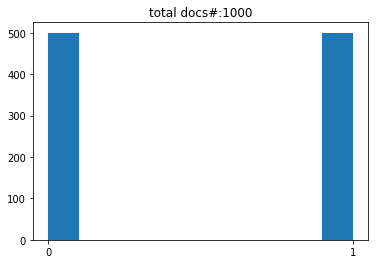

In [91]:
import matplotlib.pyplot as plt
plt.hist(y_test);
plt.xticks([0,1]);
plt.title('total docs#:%d'%len(test_vecs));


In [92]:
print([z.tags for z in x_train[:10]])


[['train_pos_0'], ['train_pos_10000'], ['train_pos_10001'], ['train_pos_10002'], ['train_pos_10003'], ['train_pos_10004'], ['train_pos_10005'], ['train_pos_10006'], ['train_pos_10007'], ['train_pos_10008']]


[['train_pos_0'], ['train_pos_10000'], ['train_pos_10001'], ['train_pos_10002'], ['train_pos_10003'], ['train_pos_10004'], ['train_pos_10005'], ['train_pos_10006'], ['train_pos_10007'], ['train_pos_10008']]
total words#:2742572
Test Accuracy: 0.50


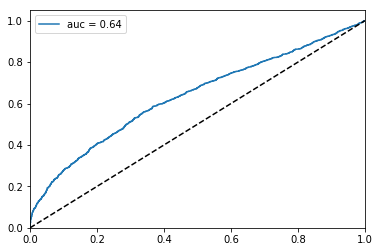

In [111]:
%matplotlib inline
##运行模块
if __name__ == "__main__":
    #设置向量维度和训练次数
    size, epoch_num = 100, 40
    #获取训练与测试数据及其类别标注
    x_train,x_test,unsup_reviews,y_train, y_test = get_dataset()
    print([z.tags for z in x_train[:10]])
    #对数据进行训练，获得模型
    model_dm,model_dbow = train(x_train,x_test,unsup_reviews,size,epoch_num)
    #从模型中抽取文档相应的向量
    train_vecs,test_vecs = get_vectors(model_dm,model_dbow)
    #使用文章所转换的向量进行情感正负分类训练
    lr=Classifier(train_vecs,y_train,test_vecs, y_test)
    #画出ROC曲线
    ROC_curve(lr,y_test)


In [109]:
from sklearn.metrics import f1_score
pred_y = lr.predict(test_vecs)
f1_score(pred_y, y_test)
lr=Classifier(train_vecs,y_train,test_vecs, y_test)

D:\Python27\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Test Accuracy: 0.50


In [98]:
model_dm.docvecs[x_test[10].tags[0]]

array([ 1.64163455e-01,  3.86242688e-01,  1.57523364e-01,  6.99698851e-02,
        1.06845617e-01,  1.20848134e-01, -1.48925725e-02, -1.69116065e-01,
        1.98309883e-01,  3.07757407e-02, -1.25744581e-01, -1.28544316e-01,
        1.35369077e-01,  9.06429347e-03,  3.26235831e-01, -3.00434753e-02,
        1.85262904e-01, -7.92576000e-02,  9.37581584e-02, -1.48358151e-01,
        4.39111702e-02, -4.12193120e-01,  1.54139161e-01, -4.25212115e-01,
        4.41485345e-01,  3.34115289e-02,  3.42638716e-02,  4.66842860e-01,
        2.46335983e-01, -3.48420233e-01, -1.13515258e-01,  1.62411794e-01,
        7.38749001e-03,  8.74557160e-03,  2.16825351e-01, -1.38794556e-01,
        1.92210376e-01, -4.26972061e-02,  2.61127025e-01,  3.97164792e-01,
        3.62905301e-02,  4.54772040e-02, -9.99554899e-03,  1.75031602e-01,
       -4.12594676e-02,  3.16922277e-01, -1.22098215e-02, -1.36185270e-02,
        4.05624390e-01, -8.87367502e-02, -9.07895807e-03, -4.53730226e-01,
        4.92073223e-02, -

In [2]:
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
train = load_svmlight_file(r'D:\sourcecode\ai-dataset\aclImdb\train\labeledBow.feat')

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Administrator.WIN-
[nltk_data]     BK34KE96UOH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True